In [1]:
from datetime import datetime
import numpy as np
from textwrap import TextWrapper
import matplotlib.pyplot as plt

from diags import Conventional

import sys
sys.path.append('/scratch1/NCEPDEV/da/Kevin.Dougherty/emcpy/src/')

from emcpy.plots.plots import Scatter, Histogram, VerticalLine
from emcpy.plots.map_plots import MapScatter
from emcpy.plots import CreateMap, CreatePlot, VariableSpecs
from emcpy.plots.map_tools import Domain, MapProjection

In [2]:
diagfile = '/scratch2/NCEPDEV/stmp1/Kevin.Dougherty/ncDiags/gdas.20200922/00/atmos/diag_conv_t_ges.2020092200.nc4'
diag_type = 'omf'
obsid = None
analysis_use = False
plot_type = ['histogram', 'map']
outdir = './'

diag = Conventional(diagfile)
variable = diag.variable

data = diag.get_data(diag_type, obsid=obsid, analysis_use=analysis_use)
lats, lons = diag.get_lat_lon(obsid=obsid, analysis_use=analysis_use)

metadata = diag.metadata

In [3]:
if variable == 'uv':
    u = data[0]
    v = data[-1]
    
    

### Mapping

In [49]:
def _get_obs_type(obs_id):
    """
    Grabs the full name of a specific observation.
    Input:
        obs_id: ID number(s) for conventional diagnostic
    Output:
        list of observation names. If ID in the list, it will return,
        the proper name. If no observation ID, returns 'All Observations'.
        If ID not in the list, returns list of string of the ID number.
    """

    obs_indicators = {
        120: "Rawinsonde",
        126: "RASS",
        130: "Aircraft: AIREP and PIREP",
        131: "Aircraft: AMDAR",
        132: "Flight-Level Reconnaissance and Profile Dropsonde",
        133: "Aircraft: MDCRS ACARS",
        134: "Aircraft: TAMDAR",
        135: "Aircraft: Canadian AMDAR",
        153: "GPS-Integrated Precipitable Water",
        180: "Surface Marine w/ Station Pressure (Ship, Buoy, C-MAN, Tide Guage)",
        181: "Surface Land w/ Station Pressure (Synoptic, METAR)",
        182: "Splash-Level Dropsonde Over Ocean",
        183: "Surface Marine or Land - Missing Station Pressure",
        187: "Surface Land - Missing Station Pressure",
        210: "Synthetic Tropical Cyclone",
        220: "Rawinsonde",
        221: "PIBAL",
        224: "NEXRAD Vertical Azimuth Display",
        228: "Wind Profiler: JMA",
        229: "Wind Profiler: PIBAL",
        230: "Aircraft: AIREP and PIREP",
        231: "Aircraft: AMDAR",
        232: "Flight-Level Reconnaissance and Profile Dropsonde",
        233: "Aircraft: MDCRS ACARS",
        234: "Aircraft: TAMDAR",
        235: "Aircraft: Canadian AMDAR",
        242: "JMA IR (Longwave) and Visible Cloud Drift Below 850mb (GMS, MTSAT, HIMAWARI)",
        243: "EUMETSAT IR (Longwave) and Visible Cloud Drift Below 850mb (METEOSAT)",
        244: "AVHRR/POES IR (Longwave) Cloud Drift",
        245: "NESDIS IR (Longwave) Cloud Drift (All Levels)",
        246: "NESDIS Imager Water Vapor (All Levels) - Cloud Top (GOES)",
        250: "JMA Imager Water Vapor (All Levels) - Cloud Top & Deep Layer (GMS, MTSAT, HIMAWARI)",
        251: "NESDIS Visible Cloud Drift (All Levels) (GOES)",
        252: "JMA IR (Longwave) and Visible Cloud Drift Above 850mb (GMS, MTSAT, HIMAWARI)",
        253: "EUMETSAT IR (Longwave) and Visible Cloud Drift Above 850mb (METEOSAT)",
        254: "EUMETSAT Imager Water Vapor (All Levels) - Cloud Top & Deep Layer (METEOSAT)",
        257: "MODIS/POES IR (Longwave) Cloud Drift (All Levels) (AQUA, TERRA)",
        258: "MODIS/POES Imager Water Vapor (All Levels) - Cloud Top (AQUA, TERRA)",
        259: "MODIS/POES Imager Water Vapor (All Levels) - Deep Layer (AQUA, TERRA)",
        280: "Surface Marine w/ Station Pressure (Ship, Buoy, C-MAN, Tide Guage)",
        281: "Surface Land w/ Station Pressure (Synoptic, METAR)",
        282: "ATLAS Buoy",
        284: "Surface Marine or Land - Missing Station Pressure",
        287: "Surface Land (METAR) - Missing Station Pressure",
        289: "SUPEROBED (1.0 Lat/Lon) Scatterometer Winds over Ocean",
        290: "Non-SUPEROBED Scatterometer Winds over Ocean"
    }

    descripts = list()
    for ids in obs_id:
        if (ids in obs_indicators.keys()) == True:
            descripts.append(obs_indicators[ids])

    if descripts:
        return descripts
    elif not obs_id:
        return ['All Observations']
    else:
        return [str(x) for x in obs_id]

def _calculate_stats(data):
    """
    Calculates n, mean, min, max,
    standard deviation, and RMSE.
    Returns dictionary with stats.
    """

    n = np.count_nonzero(~np.isnan(data))

    mean = np.nanmean(data)
    std = np.nanstd(data)
    mx = np.nanmax(data)
    mn = np.nanmin(data)

    rmse = np.sqrt(np.nanmean(np.square(data)))

    stats = {'Nobs': n,
             'Min': np.round(mn, 3),
             'Max': np.round(mx, 3),
             'Mean': np.round(mean, 3),
             'Std': np.round(std, 3),
             'RMSE': np.round(rmse, 3)
             }

    return stats

def _get_labels(metadata):
        
    var = metadata['Satellite'] if 'Satellite' in metadata else metadata['Variable']
    
    # Get title and save file name
    if metadata['Anl Use Type'] is not None:
        title = (f"{metadata['Obs Type']}: {var} - {metadata['Diag Type']}"
                 f"- Data {metadata['Anl Use Type']}")
        
        save_file = (f"{metadata['Date']:%Y%m%d%H}_{metadata['Obs Type']}_"
                     f"{var}_{metadata['Diag Type']}_{metadata['Anl Use Type']}")
        
    else:
        title = f"{metadata['Obs Type']}: {var} - {metadata['Diag Type']}"
        save_file = (f"{metadata['Date']:%Y%m%d%H}_{metadata['Obs Type']}_"
                     f"{var}_{metadata['Diag Type']}_")
    
    # Adds on specific obsid, channel, or layer info to title/save file
    if metadata['Diag File Type'] == 'conventional':
        title = title + '\n%s' % '\n'.join(metadata['ObsID Name'])
        save_file = save_file + '%s' % '_'.join(str(x) for x in metadata['ObsID'])

    elif metadata['Diag File Type'] == 'radiance':
        title = title + 'Channels: %s' % ' '.join(str(x) for x in metadata['Channels'])
        save_file = save_file + 'channels_%s' % '_'.join(str(x) for x in metadata['Channels'])
        
    else:
        layer = '_'.join(metadata['Layer'].split()) if metadata['Layer'] == 'column total' \
                else f"{metadata['Layer']:.3f}"
            
        save_file = save_file + '%s' % layer
        
    # Get date label
    date_title = metadata['Date'].strftime("%d %b %Y %Hz")
    
    labels = {
        'title': title,
        'date title': date_title,
        'save file': save_file
    }
    
    return labels


def _varspecs_name(variable):
    """
    Grabs the specific variable name to utlitize emcpy's VariableSpecs.
    """
    vardict = {
            'temperature': ['air temperature', 'tmp', 'temp', 't'],
            'specific humidity': ['q', 'spfh'],
            'u': ['eastward wind', 'ugrd'],
            'v': ['northward wind', 'vgrd'],
            'wind speed': ['windspeed'],
            'brightness temperature': ['bt']
        }

    # makes lower case and replaces underscore with space
    spec_variable = variable.lower().replace('_', ' ')

    for key in vardict.keys():
        spec_variable = key if spec_variable in vardict[key] \
            else spec_variable

    return spec_variable

def _no_data_map(plotmap, domain, metadata):
    """
    Creates a plot if there is no data that displays
    'No Data' across the map.
    """
    
    # Titles
    labels = _get_labels(metadata)
    plotmap.add_title(label=labels['title'],
                    loc='left', fontsize=12)
    plotmap.add_title(label=labels['date title'],
                    loc='right', fontsize=12,
                    fontweight='semibold')
    
    # Get center of map location
    lon1 = domain.extent[0]+180
    lon2 = domain.extent[1]+180
    xloc = (lon2 - ((lon2-lon1)/2)) - 180

    lat1 = domain.extent[2]+90
    lat2 = domain.extent[3]+90
    yloc = (lat2 - (lat2-lat1)/2) - 90
    
    # Plot text
    plotmap.add_text(xloc, yloc, 'No Data', fontsize=32,
                   alpha=0.6, horizontalalignment='center')
    
    # Return figure
    fig = plotmap.return_figure()
    plt.savefig(outdir + f"{labels['save file']}_map.png",
                bbox_inches='tight', pad_inches=0.1)
    plt.close('all')
    
    return
    

def _create_map_plot(data, metadata, lats, lons,
                     outdir, domain, projection,
                     title, date_title, xlabel,
                     ylabel, annotate_stats, 
                     colorbar, cbar_label, grid):
    """
    Function to create map plot.
    """

    # Create map object
    mymap = CreateMap(figsize=(12, 8),
                      domain=Domain(domain),
                      proj_obj=MapProjection(projection))
    # Add coastlines
    mymap.add_features(['coastlines'])
    
    # Set evaluation type to either diff or magnitude
    eval_type = 'diff' if metadata['Diag Type'] in ['omf', 'oma'] else 'magnitude'

    # Get variable specs
    spec_variable = _varspecs_name(metadata['Variable'])

    varspecs = VariableSpecs(variable=spec_variable,
                             eval_type=eval_type)
    metadata['Variable'] = varspecs.name
    
    if len(data) == 0:
        _no_data_map(mymap, domain, metadata)
        return

    # Generate plot object
    plotobj = MapScatter(latitude=lats,
                         longitude=lons,
                         data=data)

    plotobj.cmap = varspecs.cmap
    plotobj.vmin = varspecs.vmin
    plotobj.vmax = varspecs.vmax

    mymap.draw_data([plotobj])

    # Add features to the plot
    # Colorbar
    if colorbar:
        cbar_label = f"{metadata['Variable'].capitalize()} ({varspecs.units})" \
            if cbar_label is None else cbar_label

        mymap.add_colorbar(label=cbar_label,
                           label_fontsize=12,
                           extend='both')
    # Titles
    labels = _get_labels(metadata)
    
    title = labels['title'] if title is None else title
    mymap.add_title(title, loc='left', fontsize=12)
    
    if date_title:
        mymap.add_title(label=labels['date title'],
                        loc='right', fontsize=12,
                        fontweight='semibold')
    # X and Y labels
    xlabel = "Longitude" if xlabel is None else xlabel
    ylabel = "Latitude" if ylabel is None else ylabel
    
    mymap.add_xlabel(xlabel, fontsize=12)
    mymap.add_ylabel(ylabel, fontsize=12)
    
    # Annotate Stats
    if annotate_stats:
        stats_dict = _calculate_stats(data)
        # Make stats dict values str because when annotating,
        # they refuse to round??
        for key in stats_dict:
            val = str(stats_dict[key])
            stats_dict[key] = val
        
        # Each domain changes so need to set
        # values for each domain
        yloc_dict = {
            'global': -0.12,
            'north america': -0.10,
            'conus': -0.11,
            'europe': -0.095
        }

        mymap.add_stats_dict(stats_dict, yloc=yloc_dict[domain],
                             fontsize=12)
    
    # Grid
    if grid:
        mymap.add_grid()

    # Return figure
    fig = mymap.return_figure()
    plt.savefig(outdir + f"{labels['save file']}_map.png",
                bbox_inches='tight', pad_inches=0.1)
    plt.close('all')
    
    return


def plot_map(data, metadata, lats, lons, outdir='./', domain='global',
             projection='plcarr', title=None, date_title=True,
             xlabel=None, ylabel=None, annotate_stats=True, colorbar=True,
             cbar_label=None, grid=False):
    """
    Plots data on a map.
    
    Args:
        data : (array-like) data to plot
        metadata : (dict) dictionary of metadata
        lats : (array-like) latitude data
        lons : (array-like) longitude data
        outdir : (str; default='./') directory to store saved
                 figure files
        domain : (str; default='global') domain of map to plot
                 data on
        projection : (str; default='plcarr') map projection
        title : (str; default=None) text for title; if None, will
                be default title
        date_title : (str; default=None) text for date title;
                     if None, will be default date title
        xlabel : (str; default=None) text for x label; if None,
                 will be 'Longitude'
        ylabel : (str; default=None) text for y label; if None,
                 will be 'Latitude'
        annotate_stats : (bool; default=True) adds stats to figure
        colorbar : (bool; default=True) adds colorbar to figure
        cbar_label : (str; default=None) text for colorbar label;
                     if None, will use default label
        grid : (bool; default=False) adds grid to plot
    """
    if metadata['Diag File Type'] == 'conventional':
        # Grab observation type if conventional data
        metadata['ObsID Name'] = _get_obs_type(metadata['ObsID'])

        # Handles analysis use data
        anl_use = metadata['Anl Use']
        
    if anl_use:
        for anl_type in data.keys():
            metadata['Anl Use Type'] = anl_type
            
            _create_map_plot(data[anl_type], metadata,
                             lats[anl_type], lons[anl_type],
                             outdir, domain, projection,
                             title, date_title, xlabel,
                             ylabel, annotate_stats, 
                             colorbar, cbar_label, grid)
            
    else:     
        metadata['Anl Use Type'] = None
        _create_map_plot(data, metadata, lats, lons, outdir,
                         domain, projection, title, date_title,
                         xlabel, ylabel, annotate_stats, 
                         colorbar, cbar_label, grid)
        
    return

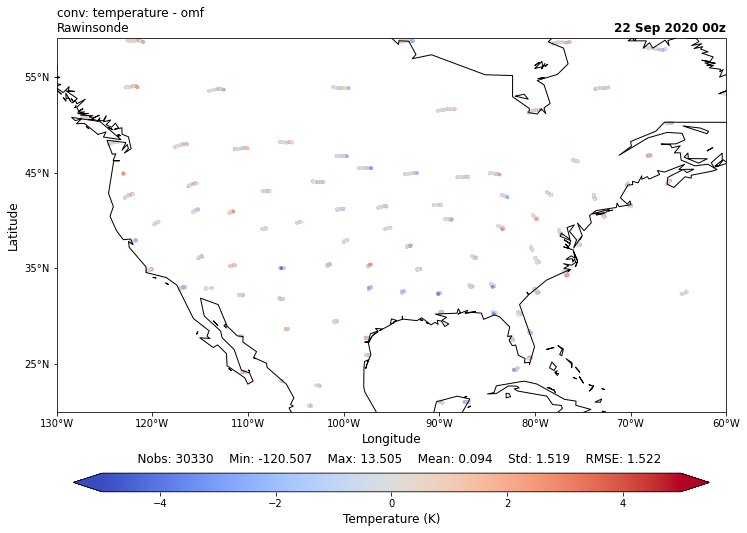

In [50]:
diagfile = '/scratch2/NCEPDEV/stmp1/Kevin.Dougherty/ncDiags/gdas.20200922/00/atmos/diag_conv_t_ges.2020092200.nc4'
diag_type = 'omf'
obsid = [120]
analysis_use = False
plot_type = ['histogram', 'map']
outdir = './'

diag = Conventional(diagfile)
variable = diag.variable

data = diag.get_data(diag_type, obsid=obsid, analysis_use=analysis_use)
lats, lons = diag.get_lat_lon(obsid=obsid, analysis_use=analysis_use)

metadata = diag.metadata

# data = np.array([285])
# lats = np.array([0.0])
# lons = np.array([0.0])

plot_map(data, metadata, lats, lons, outdir='./', domain='conus', projection='plcarr')

### Histogram

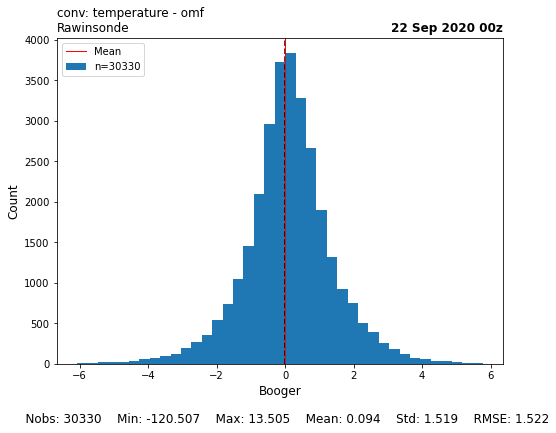

In [11]:
def _get_bins(eval_type, stats):
    """
    Calculates bins to use for histogram plot.
    """
    binsize = stats['Std']/5

    if eval_type == 'diff':
        bins = np.arange(0-(4*stats['Std']),
                         0+(4*stats['Std']),
                         binsize)
        
    else:
        bins = np.arange(stats['Mean']-(4*stats['Std']),
                         stats['Mean']+(4*stats['Std']),
                         binsize)
        
    return bins
    
def _no_data_histogram(data, plotobj, metadata):
    """
    Creates histogram with either 'No Data' or
    'Single Observation' depending on length of data.
    """
    # Titles
    labels = _get_labels(metadata)
    plotobj.add_title(label=labels['title'],
                     loc='left', fontsize=12)
    plotobj.add_title(label=labels['date title'],
                     loc='right', fontsize=12,
                     fontweight='semibold')
    
    if len(data) == 0:
        text = 'No Data'
    else:
        text = 'Single\nObservation'
        
        # Annotate Stats
        stats_dict = _calculate_stats(data)
        plotobj.add_stats_dict(stats_dict, fontsize=12)
        
    
    plotobj.add_text(0.5, 0.5, text, fontsize=32,
                    alpha=0.6, horizontalalignment='center')
    
    # Return figure
    fig = plotobj.return_figure()
    plt.savefig(outdir + f"{labels['save file']}_hist.png",
                bbox_inches='tight', pad_inches=0.1)
    plt.close('all')
    
    return

def _create_hist_plot(data, metadata, outdir, color, legend,
                      grid, plot_mean, plot_zero, title,
                      date_title, xlabel, ylabel,
                      annotate_stats):
    """
    
    """
    myplot=CreatePlot()
    
    spec_variable = _varspecs_name(metadata['Variable'])

    # Set evaluation type to either diff or magnitude
    eval_type = 'diff' if metadata['Diag Type'] in ['omf', 'oma'] else 'magnitude'
    varspecs = VariableSpecs(variable=spec_variable,
                             eval_type=eval_type)
    metadata['Variable'] = varspecs.name
    
    if len(data) <= 1:
        _no_data_histogram(data, myplot, metadata)
        
        return
    
    # Get Stats
    stats_dict = _calculate_stats(data)
    
    # Get bins
    bins = _get_bins(eval_type, stats_dict)
    
    # Create histogram plot object
    histobj = Histogram(data)
    histobj.bins=bins
    histobj.color=color

    myplot.draw_data([histobj])
    
    if eval_type == 'diff' and plot_zero:
        zeroline = VerticalLine(0)
        zeroline.color = 'k'
        zeroline.linestyle = 'dashed'
        zeroline.linewidth = 1.5
        
        myplot.draw_data([zeroline])
    
    if plot_mean:
        meanline = VerticalLine(0)
        meanline.color = 'red'
        meanline.linestyle = 'solid'
        meanline.linewidth = 1
        meanline.label = 'Mean'
        
        myplot.draw_data([meanline])

    if legend:
        myplot.add_legend()

    if grid:
        myplot.add_grid()
        
    # Titles
    labels = _get_labels(metadata)
    
    if title:
        myplot.add_title(label=labels['title'],
                        loc='left', fontsize=12)
    if date_title:
        myplot.add_title(label=labels['date title'],
                        loc='right', fontsize=12,
                        fontweight='semibold')
    
    # X and Y labels
    xlabel = f"{varspecs.name.capitalize()} ({varspecs.units})" \
        if xlabel is None else xlabel
    ylabel = "Count" if ylabel is None else ylabel
    
    myplot.add_xlabel(xlabel, fontsize=12)
    myplot.add_ylabel(ylabel, fontsize=12)
        
    if annotate_stats:
        # Make stats dict values str because when annotating,
        # they refuse to round??
        for key in stats_dict:
            val = str(stats_dict[key])
            stats_dict[key] = val
            
        myplot.add_stats_dict(stats_dict, yloc=-0.15, fontsize=12)

    # Return figure
    fig = myplot.return_figure()
    plt.savefig(outdir + f"{labels['save file']}_hist.png",
                bbox_inches='tight', pad_inches=0.1)
    plt.close('all')
    
    return
    

def plot_histogram(data, metadata, outdir='./', color='tab:blue',
                   legend=True, grid=False, plot_mean=True,
                   plot_zero=True, title=True, date_title=True,
                   xlabel=None, ylabel=None,
                   annotate_stats=True):
    """
    Plots data on a map.
    
    Args:
        data : (array-like) data to plot
        metadata : (dict) dictionary of metadata
        outdir : (str; default='./') directory to store saved
                 figure files
        color : (str; default='tab:blue') color of histogram
    """
    if metadata['Diag File Type'] == 'conventional':
        # Grab observation type if conventional data
        metadata['ObsID Name'] = _get_obs_type(metadata['ObsID'])

        # Handles analysis use data
        anl_use = metadata['Anl Use']
        
    if anl_use:
        for anl_type in data.keys():
            metadata['Anl Use Type'] = anl_type
            
            _create_hist_plot(data[anl_type],
                              metadata, outdir,
                              color, legend, grid,
                              plot_mean, plot_zero,
                              title, date_title,
                              xlabel, ylabel,
                              annotate_stats)
            
    else:     
        metadata['Anl Use Type'] = None
        _create_hist_plot(data, metadata, outdir, color,
                          legend, grid, plot_mean, plot_zero,
                          title, date_title, xlabel, ylabel,
                          annotate_stats)
        
    return

##################
# data=np.array([250])
plot_histogram(data, metadata)
    
#     return

# histobj = Histogram(data)
# histobj.bins=50
# histobj.color='tab:green'
# histobj.alpha=0.5

# myplot=CreatePlot()
# myplot.draw_data([histobj])
# myplot.add_legend()
# myplot.add_grid()

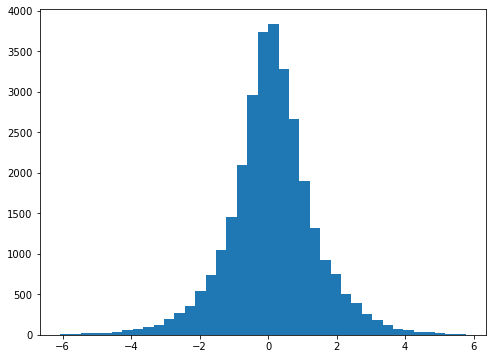

In [38]:
myplot=CreatePlot()
    
spec_variable = _varspecs_name(metadata['Variable'])

varspecs = VariableSpecs(variable=spec_variable,
                         eval_type='magnitude')
metadata['Variable'] = varspecs.name

# if len(data) <= 1:
#     _no_data_histogram(data, myplot, metadata)

#     return

# Get Stats
stats_dict = _calculate_stats(data)

# Create histogram plot object
histobj = Histogram(data)

std = float(stats_dict['Std'])

binsize = std/5

bins = np.arange(0-(4*std), 0+(4*std), binsize)

histobj.bins = bins
myplot.draw_data([histobj])


In [42]:
myplot.ax.axvline(stats_dict['Mean'], color='r', linestyle='solid', linewidth=1)

In [12]:
# Get variable specs
spec_variable = _varspecs_name(metadata['Variable'])

varspecs = VariableSpecs(variable=spec_variable,
                         eval_type='magnitude')
metadata['Variable'] = varspecs.name

In [14]:
varspecs.__dict__

{'eval_type': 'magnitude',
 'name': 'temperature',
 'sname': 't',
 'type': 'conventional',
 'units': 'K',
 'range': [220, 320],
 'contour_int': 5,
 'contours': array([220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280,
        285, 290, 295, 300, 305, 310, 315, 320]),
 'cmap': 'rainbow',
 'vmin': 220,
 'vmax': 320}

In [ ]:
domain='global'
projection='plcarr'

if metadata['Diag File Type'] == 'conventional':
    # Grab observation type if conventional data
#     metadata['ObsID Name'] = _get_obs_type(metadata['ObsID'])

    # Handles analysis use data
    anl_use = metadata['Anl Use']

metadata['Anl Use Type'] = None
    
domain = Domain(domain)
proj_obj = MapProjection(projection)

# Create map object
mymap = CreateMap(figsize=(12, 8),
                  domain=domain,
                  proj_obj=proj_obj)
# Add coastlines
mymap.add_features(['coastlines'])

# Generate plot object
plotobj = MapScatter(latitude=lats,
                     longitude=lons,
                     data=data)

# Set evaluation type to either diff or magnitude
eval_type = 'diff' if metadata['Diag Type'] in ['omf', 'oma'] else 'magnitude'

# Get variable specs
spec_variable = _varspecs_name(metadata['Variable'])

varspecs = VariableSpecs(variable=spec_variable,
                         eval_type=eval_type)
metadata['Variable'] = varspecs.name

plotobj.cmap = varspecs.cmap
plotobj.vmin = varspecs.vmin
plotobj.vmax = varspecs.vmax

mymap.draw_data([plotobj])

# Add features to the plot
# Colorbar
cmap_label = f"{metadata['Variable']} ({varspecs.units})"
mymap.add_colorbar(label= cmap_label,
                   label_fontsize=12, extend='both')
# Titles
labels = _get_labels(metadata)
mymap.add_title(label=labels['title'],
                loc='left', fontsize=12)
mymap.add_title(label=labels['date title'],
                loc='right', fontsize=12,
                fontweight='semibold')
# Annotate Stats
stats_dict = _calculate_stats(data)
mymap.add_stats_dict(stats_dict, fontsize=12)
# mymap.add_grid()

# Return figure
fig = mymap.return_figure()
# varspecs.__dict__

In [ ]:
domain.__dict__

In [ ]:
stats_dict

In [ ]:
outstr = ''
for key, value in stats_dict.items():
    outstr = outstr + f'    {key}: {value}'
    
outstr

In [ ]:
for key, value in stats_dict.items():
    print(key, value)
    string = f'{value}'
    
string